## Code to train DQN with APSF representations

This code is similar to how policy general features are created. Start with that notebook first if you're here for the first time. The difference here is that the pretraining phase uses a CNN to generalize across multiple contexts (DyFourRooms is used instead of FourRooms) for pretraining.

In [1]:
# Add location to DeepRL library (based on a 2019 version of the library)
import sys,os
sys.path.append('../..')

from deep_rl_old import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

select_device(0)

### Training a baseline DQN

In [2]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    if(config.hidden_nodes is None):
        hidden_nodes = 16
    else:
        hidden_nodes = config.hidden_nodes
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, \
                                                                     hidden_units=(hidden_nodes,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
game = 'Dy-FourRoomsMatrix'
agent = dqn_feature(game=game)

2020-11-28 16:03:22,187 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-11-28 16:03:32,239 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-11-28 16:03:39,535 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-11-28 16:03:46,906 - root - INFO: steps 15000, episodic_return_test -180.00(18.97)
2020-11-28 16:03:54,133 - root - INFO: steps 20000, episodic_return_test -161.20(24.54)
2020-11-28 16:04:01,289 - root - INFO: steps 25000, episodic_return_test -180.10(18.88)
2020-11-28 16:04:08,430 - root - INFO: steps 30000, episodic_return_test -142.00(28.02)
2020-11-28 16:04:15,705 - root - INFO: steps 35000, episodic_return_test -160.20(25.17)
2020-11-28 16:04:22,914 - root - INFO: steps 40000, episodic_return_test -142.40(27.82)
2020-11-28 16:04:30,311 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-11-28 16:04:37,642 - root - INFO: steps 50000, episodic_return_test -180.00(18.97)
Process AsyncReplay-1:
Traceback (most re

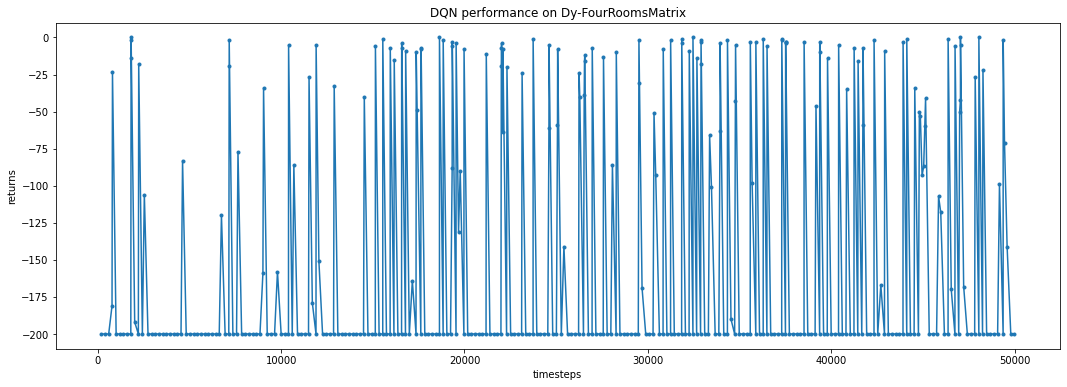

(Text(0.5, 1.0, 'DQN performance on Dy-FourRoomsMatrix'), None)

In [4]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

### Learning the state representations using APSF (unsupervised exploration)

In [21]:
class SRNetCNN(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(1000,), gate=F.relu, config=1):
        """
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetCNN, self).__init__()
        self.body = body
        self.output_dim = output_dim
        self.width = int(np.sqrt(body.feature_dim))

        # CNN layers
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.fc_size = 128 * ((self.width - (3-1)*2) // 2) ** 2

        # FC layers
        dims = (self.fc_size,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, body.feature_dim)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)
        self.to(Config.DEVICE)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi

        # Convert to image
        psi = psi.view(phi.size(0), 1, self.width, self.width)

        # Conv layers
        psi = self.conv1(psi)
        psi = F.relu(psi)
        psi = self.conv2(psi)
        psi = F.relu(psi)
        psi = F.max_pool2d(psi, 2)
        psi = torch.flatten(psi, 1)

        # FC layers
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [22]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(2000,), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 3e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()

In [23]:
avdsr = avdsr_feature(game='Dy-FourRoomsMatrixNoTerm', agents=[agent], choice=0)

2020-11-28 16:31:30,297 - root - INFO: steps 0, 299593142.86 steps/s
2020-11-28 16:31:33,228 - root - INFO: steps 1000, 342.31 steps/s
2020-11-28 16:31:36,168 - root - INFO: steps 2000, 340.98 steps/s
2020-11-28 16:31:39,058 - root - INFO: steps 3000, 346.93 steps/s
2020-11-28 16:31:41,997 - root - INFO: steps 4000, 341.22 steps/s
2020-11-28 16:31:44,928 - root - INFO: steps 5000, 342.07 steps/s
2020-11-28 16:31:47,865 - root - INFO: steps 6000, 341.31 steps/s
2020-11-28 16:31:50,795 - root - INFO: steps 7000, 342.23 steps/s
2020-11-28 16:31:53,730 - root - INFO: steps 8000, 341.63 steps/s
2020-11-28 16:31:56,686 - root - INFO: steps 9000, 339.16 steps/s
2020-11-28 16:31:59,606 - root - INFO: steps 10000, 343.39 steps/s
2020-11-28 16:32:02,546 - root - INFO: steps 11000, 340.90 steps/s
2020-11-28 16:32:05,475 - root - INFO: steps 12000, 342.36 steps/s
2020-11-28 16:32:08,425 - root - INFO: steps 13000, 339.86 steps/s
2020-11-28 16:32:11,381 - root - INFO: steps 14000, 339.18 steps/s
20

In [24]:
avdsr.loss_vec[:15]

[0.0046242401003837585,
 7.566076755523682,
 0.1383778303861618,
 0.006133930291980505,
 0.0031551022548228502,
 0.0030154050327837467,
 0.003067447105422616,
 0.0031056173611432314,
 0.003113123122602701,
 0.0030163335613906384,
 0.0032773881684988737,
 0.003214500145986676,
 0.003180299885571003,
 0.004045015200972557,
 0.003520940663293004]

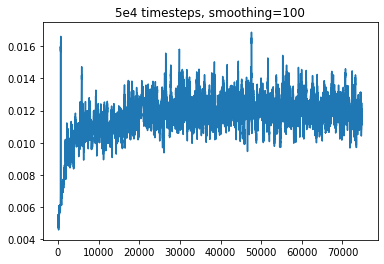

(Text(0.5, 1.0, '5e4 timesteps, smoothing=100'), None)

In [25]:
loss_lr_em3 = avdsr.loss_vec
kernel = 100
plt.plot(convolve(avdsr.loss_vec[20:], kernel))
plt.title('5e4 timesteps, smoothing=' + str(kernel)), plt.show()

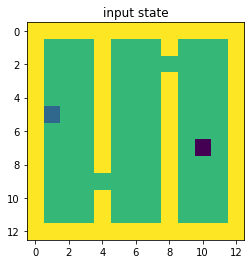

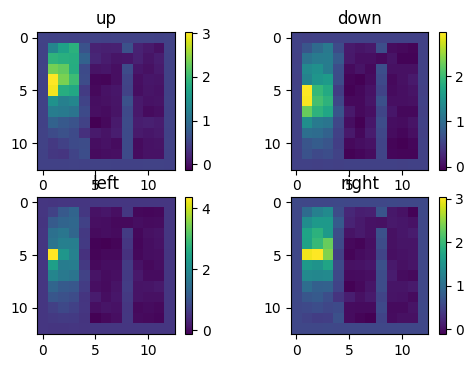

In [27]:
from deep_rl_old.component.fourrooms import FourRoomsMatrix
env = FourRoomsMatrix(layout='3rooms')
state = env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
# env.current_cell = (5,5)
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

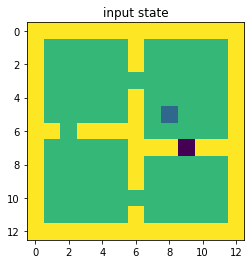

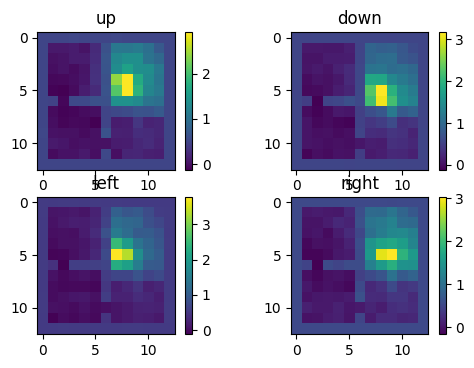

In [28]:
from deep_rl_old.component.fourrooms import FourRoomsMatrix
env = FourRoomsMatrix(layout='4rooms')
state = env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
# env.current_cell = (5,5)
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [40]:
# g = [21, 28, 84, 91]
c = np.ones(101)*4
# Set colors based on the environment here.
room1 = list(range(0,22))
room2 = list(range(23,67)) 
room3 = list(range(68,101))
connect = [22, 67]
c[room1] = 2
c[room2] = 3
c[room3] = 4
c[connect] = [-1, -1]
env = FourRoomsMatrix()
psi_all = np.zeros((101,169*4))
for i in range(101):
    state = env.reset(init=i)
    _, out, _ = avdsr.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()

psi_all.shape

(101, 676)

Text(0.5, 1.0, 'Principle components of SFs using PCA')

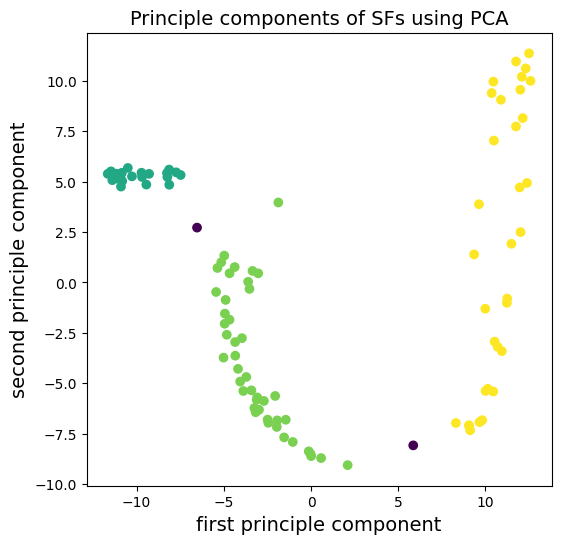

In [41]:
from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=100)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)
# plt.colorbar()
plt.title('Principle components of SFs using PCA', fontsize=14)

In [43]:
# from deep_rl.component.fourrooms import *
g = [21, 28, 84, 91]
c = np.ones(104)*4
room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
connect = [25, 51, 62, 88]
c[room1] = 1
c[room2] = 2
c[room3] = 3
c[connect] = [-1, -1, -1, -1]
env = FourRoomsMatrix(layout='4rooms')
psi_all = np.zeros((104,169*4))
for i in range(104):
    state = env.reset(init=i)
    _, out, _ = avdsr.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()

psi_all.shape

(104, 676)

Text(0.5, 1.0, 'Principle components of SFs using PCA')

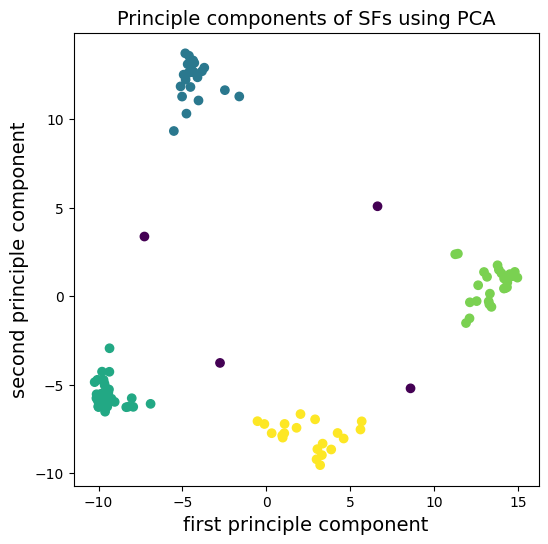

In [44]:
from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=100)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)
# plt.colorbar()
plt.title('Principle components of SFs using PCA', fontsize=14)

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [34]:
# UNCOMMENT TO SAVE THE TRAINED NETWORK
# torch.save(avdsr.network.state_dict(), 'avdsr.wts')
# UNCOMMENT TO LOAD THE TRAINED NETWORK

In [36]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.async_actor = False
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(2000,), config=config.style) #CHECK
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [37]:
def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [38]:
r_c0 = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr, style=0)
r_c1 = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr, style=1)
r_dqn_base_16 = runNAgents(dqn_feature, runs=1)


runs:   0%|          | 0/1 [00:00<?, ?it/s]

IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-11-28 16:53:25,293 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
Process AsyncReplay-8:
Traceback (most recent call last):
  File "/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../../deep_rl_old/component/replay.py", line 138, in run
    set_up_cache()
  File "../../deep_rl_old/component/replay.py", line 113, in set_up_cache
    batch_data = [tensor(x) for x in batch_data]
  File "../../deep_rl_old/component/replay.py", line 113, in <listcomp>
    batch_data = [tensor(x) for x in batch_data]
  File "../../deep_rl_old/utils/torch_utils.py", line 24, in tensor
    x = torch.tensor(x, device=Config.DEVICE, dtype=torch.float32)
RuntimeError: CUDA error: initialization error


KeyboardInterrupt: 

In [ ]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

In [ ]:
rewards_dict = {'DQN (h=(16,))': r_dqn_base_16[1:],
                'APSF($\pi_{\epsilon=1}$) - 169 parameters': r_c0[1:],
                'APSF($\pi_{\epsilon=1}$) - 2708 parameters': r_c1[1:],
               }

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on 3rooms(h) env')